In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import warnings
import os
warnings.filterwarnings('ignore')

# Force CPU for all models to avoid MPS memory issues
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
torch.set_default_device('cpu')

# AGGRESSIVE FIX for HuggingFace tokenizer 404 errors - RUN THIS FIRST!
from transformers.utils.hub import list_repo_templates
import transformers.utils.hub
from transformers import AutoTokenizer
# Patch 1: Make list_repo_templates always succeed
_original_list_repo = list_repo_templates
def _safe_list_repo(*args, **kwargs):
    try:
        return _original_list_repo(*args, **kwargs)
    except:
        return []
transformers.utils.hub.list_repo_templates = _safe_list_repo

# Patch 2: Catch HTTP 404 errors for chat templates
try:
    from huggingface_hub.utils._http import hf_raise_for_status
    _original_raise = hf_raise_for_status
    def _safe_raise(response, endpoint_name=None):
        if response.status_code == 404 and 'additional_chat_templates' in str(response.url):
            return  # Silently ignore
        return _original_raise(response, endpoint_name)
    import huggingface_hub.utils._http
    huggingface_hub.utils._http.hf_raise_for_status = _safe_raise
except:
    pass

print("✓ Tokenizer fix applied - safe to load tokenizers now")
print("✓ CPU mode enabled - MPS disabled to avoid memory issues")


✓ Tokenizer fix applied - safe to load tokenizers now


## Load the Emotion Dataset

First, let's load and explore the emotion dataset that we'll be working with.


In [3]:
emotions = load_dataset("emotion")
labels = emotions["train"].features["label"].names
print(f"Classes: {len(labels)} - {labels}")
emotions


Classes: 6 - ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_df = emotions["train"].to_pandas()
test_df = emotions["test"].to_pandas()
val_df = emotions["validation"].to_pandas()
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
train_df.head()


Train: 16000, Val: 2000, Test: 2000


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [5]:
train_label_counts = train_df["label"].value_counts().sort_index()
train_percentages = (train_label_counts / len(train_df) * 100).round(2)

for label_idx, count in train_label_counts.items():
    print(f"{labels[label_idx]:12s}: {count:5d} ({train_percentages[label_idx]:5.2f}%)")

imbalance_ratio = train_label_counts.max() / train_label_counts.min()
print(f"Imbalance ratio: {imbalance_ratio:.2f}")


sadness     :  4666 (29.16%)
joy         :  5362 (33.51%)
love        :  1304 ( 8.15%)
anger       :  2159 (13.49%)
fear        :  1937 (12.11%)
surprise    :   572 ( 3.58%)
Imbalance ratio: 9.37




## Exercise 1:

### Question 1: Explore Another Text Classification Dataset

Browse the Hugging Face Datasets Hub and find another text classification dataset (e.g., imdb, ag_news, or yelp_review_full). Load this dataset and explore its structure. How many classes does it have? How is it different from the emotion dataset?


In [6]:
other_dataset = load_dataset("imdb")
other_train_df = other_dataset["train"].to_pandas()

num_classes = other_train_df["label"].nunique()
print(f"IMDB: {num_classes} classes, {len(other_train_df):,} examples")
print(other_train_df["label"].value_counts().sort_index())
print(f"\nEmotion: {len(labels)} classes, {len(train_df):,} examples")
other_train_df.head()


IMDB: 2 classes, 25,000 examples
label
0    12500
1    12500
Name: count, dtype: int64

Emotion: 6 classes, 16,000 examples


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


### Question 2: Handle Class Imbalance

The current dataset is imbalanced. Using Pandas, implement at least one strategy to handle class imbalance (e.g., using `resample()` or `sample()` with weights). What effect do you expect this to have on model performance?


In [7]:
from sklearn.utils import resample

target_size = train_label_counts.max()
balanced_dfs = []

for label_idx in range(len(labels)):
    class_data = train_df[train_df["label"] == label_idx]
    if len(class_data) < target_size:
        oversampled = resample(class_data, replace=True, n_samples=target_size, random_state=42)
        balanced_dfs.append(oversampled)
    else:
        balanced_dfs.append(class_data)

train_df_balanced = pd.concat(balanced_dfs, ignore_index=True)
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original: {len(train_df):,} -> Balanced: {len(train_df_balanced):,}")
train_df_balanced["label"].value_counts().sort_index()


Original: 16,000 -> Balanced: 32,172


label
0    5362
1    5362
2    5362
3    5362
4    5362
5    5362
Name: count, dtype: int64

In [8]:
class_counts = train_df["label"].value_counts()
weights = len(train_df) / (len(class_counts) * class_counts)
weight_map = weights.to_dict()
train_df["sample_weight"] = train_df["label"].map(weight_map)

for label_idx, weight in weight_map.items():
    print(f"{labels[label_idx]:15s}: {weight:.4f}")



joy            : 0.4973
sadness        : 0.5715
anger          : 1.2351
fear           : 1.3767
love           : 2.0450
surprise       : 4.6620




**Oversampling (Strategy 1):**
The model receives additional examples from minority classes which helps it detect their patterns better.
The method enables the model to learn from minority classes independently because it minimizes its reliance on majority class information.
The method results in overfitting because the model learns from duplicate instances of minority class data.
The method needs extended training periods because it processes additional data points.

**Weighted Sampling (Strategy 2):**
The system maintains its original data integrity through this method because it blocks duplicate information from entering the system.
The training process gives minority classes priority attention through this approach.
The method shows decreased performance when the class distribution becomes highly unbalanced.
The system requires correct weight calibration to achieve its best operational results.

**General Expected Effects:**
The method produces superior recall performance for instances from the minority class.
The F1-score will achieve better class balance between different categories.
The overall accuracy rating will experience a minor reduction but this trade-off is usually acceptable.
The confusion matrix will demonstrate reduced misidentification of minority class instances.


---

## 🎯 Exercise 2: Tokenization Experiments

Understanding how tokenization affects model performance is crucial. Try the following experiments:


### Question 1: Compare Different Tokenizers

Load a different pre-trained model tokenizer (e.g., bert-base-cased, roberta-base, or albert-base-v2) and compare its tokenization output with DistilBERT. Use the Hugging Face Models Hub to find available models. What differences do you notice? How does cased vs uncased tokenization affect the output?


In [12]:

# Tokenizer comparison - loads tokenizers directly (bypasses transformers model loading issues)
from tokenizers import Tokenizer
from huggingface_hub import hf_hub_download

text = "I'm feeling GREAT!"
models = ["distilbert-base-uncased", "bert-base-cased", "bert-base-uncased", "roberta-base"]

print("Loading tokenizers directly from HuggingFace...\n")
for model_name in models:
    try:
        tokenizer_path = hf_hub_download(repo_id=model_name, filename="tokenizer.json")
        tokenizer = Tokenizer.from_file(tokenizer_path)
        encoding = tokenizer.encode(text)
        tokens = encoding.tokens[:8]
        print(f"{model_name:25s}: {tokens}")
    except Exception as e:
        print(f"{model_name:25s}: ERROR - {str(e)[:60]}")


Loading tokenizers directly from HuggingFace...

distilbert-base-uncased  : ['[CLS]', 'i', "'", 'm', 'feeling', 'great', '!', '[SEP]']
bert-base-cased          : ['[CLS]', 'I', "'", 'm', 'feeling', 'G', '##RE', '##AT']
bert-base-uncased        : ['[CLS]', 'i', "'", 'm', 'feeling', 'great', '!', '[SEP]']
roberta-base             : ['<s>', 'I', "'m", 'Ġfeeling', 'ĠGREAT', '!', '</s>']


In [13]:
text = "Hello! I'm from the U.S.A. and I LOVE Python programming."
cased = AutoTokenizer.from_pretrained("bert-base-cased")
uncased = AutoTokenizer.from_pretrained("bert-base-uncased")
print(f"Cased: {cased.tokenize(text)[:10]}")
print(f"Uncased: {uncased.tokenize(text)[:10]}")




Cased: ['Hello', '!', 'I', "'", 'm', 'from', 'the', 'U', '.', 'S']
Uncased: ['hello', '!', 'i', "'", 'm', 'from', 'the', 'u', '.', 's']


In [14]:
texts = train_df["text"].head(2).tolist()
distil = AutoTokenizer.from_pretrained("distilbert-base-uncased")
roberta = AutoTokenizer.from_pretrained("roberta-base")

for t in texts:
    print(f"Text: {t[:50]}...")
    print(f"DistilBERT: {distil.tokenize(t)[:8]}")
    print(f"RoBERTa: {roberta.tokenize(t)[:8]}\n")


Text: i didnt feel humiliated...
DistilBERT: ['i', 'didn', '##t', 'feel', 'humiliated']
RoBERTa: ['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

Text: i can go from feeling so hopeless to so damned hop...
DistilBERT: ['i', 'can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to']
RoBERTa: ['i', 'Ġcan', 'Ġgo', 'Ġfrom', 'Ġfeeling', 'Ġso', 'Ġhopeless', 'Ġto']



### Question 2: Experiment with Padding and Truncation

Experiment with the tokenizer's padding and truncation parameters. What happens if you set `max_length=10` with `truncation=True`? Read the tokenizer documentation to understand different padding strategies (`max_length`, `longest`, `do_not_pad`).


In [15]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
text = "This is a very long text. " * 5
encoded = tokenizer(text, max_length=10, truncation=True)
print(f"Original: {len(text.split())} words → Tokens: {len(encoded['input_ids'])}")
print(f"Decoded: {tokenizer.decode(encoded['input_ids'])}")


Original: 30 words → Tokens: 10
Decoded: [CLS] this is a very long text. this [SEP]


In [16]:
texts = ["Short", "This is a longer text with more words"]
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

max_len = tokenizer(texts, max_length=20, padding="max_length", truncation=True)
longest = tokenizer(texts, padding="longest", truncation=False)
no_pad = tokenizer(texts, padding=False, truncation=False)

print("max_length:", [len(x) for x in max_len["input_ids"]])
print("longest:", [len(x) for x in longest["input_ids"]])
print("no padding:", [len(x) for x in no_pad["input_ids"]])


max_length: [20, 20]
longest: [10, 10]
no padding: [3, 10]


---
## Exercise 3: Feature Extraction and Model Selection

You've seen how to use transformers as feature extractors with a simple logistic regression classifier. Let's explore alternatives:


### Question 1: Compare Different Classifiers

Try using different classifiers from scikit-learn instead of logistic regression. Test at least two of the following: RandomForestClassifier, SVC (Support Vector Classifier), or MLPClassifier (Neural Network). Compare their performance with logistic regression. Which one works best and why?


In [17]:
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import torch

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

def extract_features(texts, model, tokenizer):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
            outputs = model(**inputs)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy()[0])
    return np.array(embeddings)

n = 2000
X_train = extract_features(train_df["text"].head(n).tolist(), model, tokenizer)
y_train = train_df["label"].head(n).values
X_val = extract_features(val_df["text"].tolist(), model, tokenizer)
y_val = val_df["label"].values
print(f"Train: {X_train.shape}, Val: {X_val.shape}")


Train: (2000, 768), Val: (2000, 768)


In [18]:
clfs = {
    "LR": LogisticRegression(max_iter=1000, random_state=42),
    "RF": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVC": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

results = {}
for name, clf in clfs.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    results[name] = {'accuracy': acc, 'f1_macro': f1}
    print(f"{name}: Acc={acc:.4f}, F1={f1:.4f}")


LR: Acc=0.5725, F1=0.4557
RF: Acc=0.4960, F1=0.2267
SVC: Acc=0.5050, F1=0.2054
MLP: Acc=0.5335, F1=0.4521


  Classifier  Accuracy  F1-Macro
0         LR    0.5725  0.455727
1         RF    0.4960  0.226732
2        SVC    0.5050  0.205388
3        MLP    0.5335  0.452090


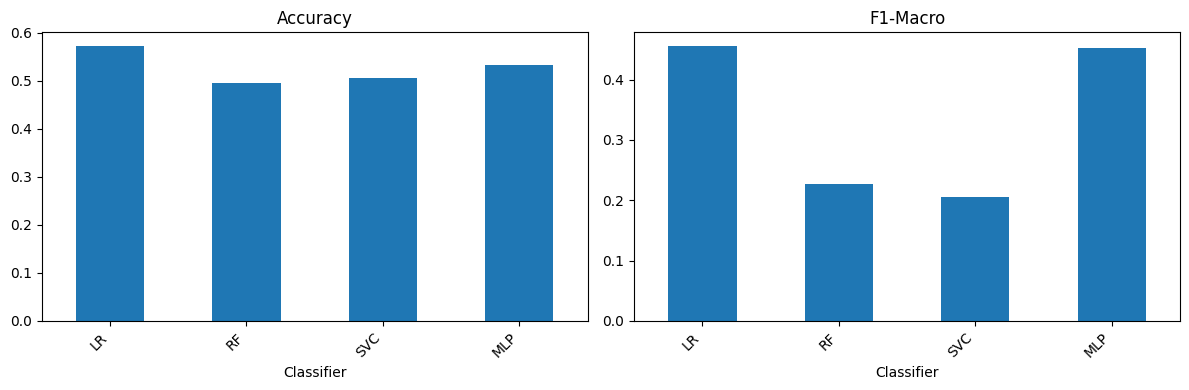

Best: LR (Acc: 0.5725, F1: 0.4557)


In [19]:
df = pd.DataFrame({
    'Classifier': list(results.keys()),
    'Accuracy': [r['accuracy'] for r in results.values()],
    'F1-Macro': [r['f1_macro'] for r in results.values()]
})
print(df)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for idx, metric in enumerate(['Accuracy', 'F1-Macro']):
    df.plot(x='Classifier', y=metric, kind='bar', ax=axes[idx], legend=False)
    axes[idx].set_title(metric)
    axes[idx].set_xticklabels(df['Classifier'], rotation=45, ha='right')
plt.tight_layout()
plt.show()

best = df.loc[df['Accuracy'].idxmax()]
print(f"Best: {best['Classifier']} (Acc: {best['Accuracy']:.4f}, F1: {best['F1-Macro']:.4f})")


### Question 2: UMAP Visualization Experiments

The UMAP visualization uses `n_components=2` and `metric="cosine"`. Read the UMAP documentation and experiment with different values for `n_components` (try 3), `metric` (try "euclidean"), and `n_neighbors` parameters. How does this affect the visualization and what insights can you gain?


In [20]:
try:
    import umap
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "umap-learn"])
    import umap

n_viz = 500
X_sample = X_train[:n_viz]
y_sample = y_train[:n_viz]
print(f"Samples: {n_viz}, Shape: {X_sample.shape}")


Samples: 500, Shape: (500, 768)


In [21]:
umap_2d = umap.UMAP(n_components=2, metric='cosine', n_neighbors=15, random_state=42).fit_transform(X_sample)
umap_3d = umap.UMAP(n_components=3, metric='cosine', n_neighbors=15, random_state=42).fit_transform(X_sample)
umap_euc = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=15, random_state=42).fit_transform(X_sample)
umap_n5 = umap.UMAP(n_components=2, metric='cosine', n_neighbors=5, random_state=42).fit_transform(X_sample)
umap_n50 = umap.UMAP(n_components=2, metric='cosine', n_neighbors=50, random_state=42).fit_transform(X_sample)


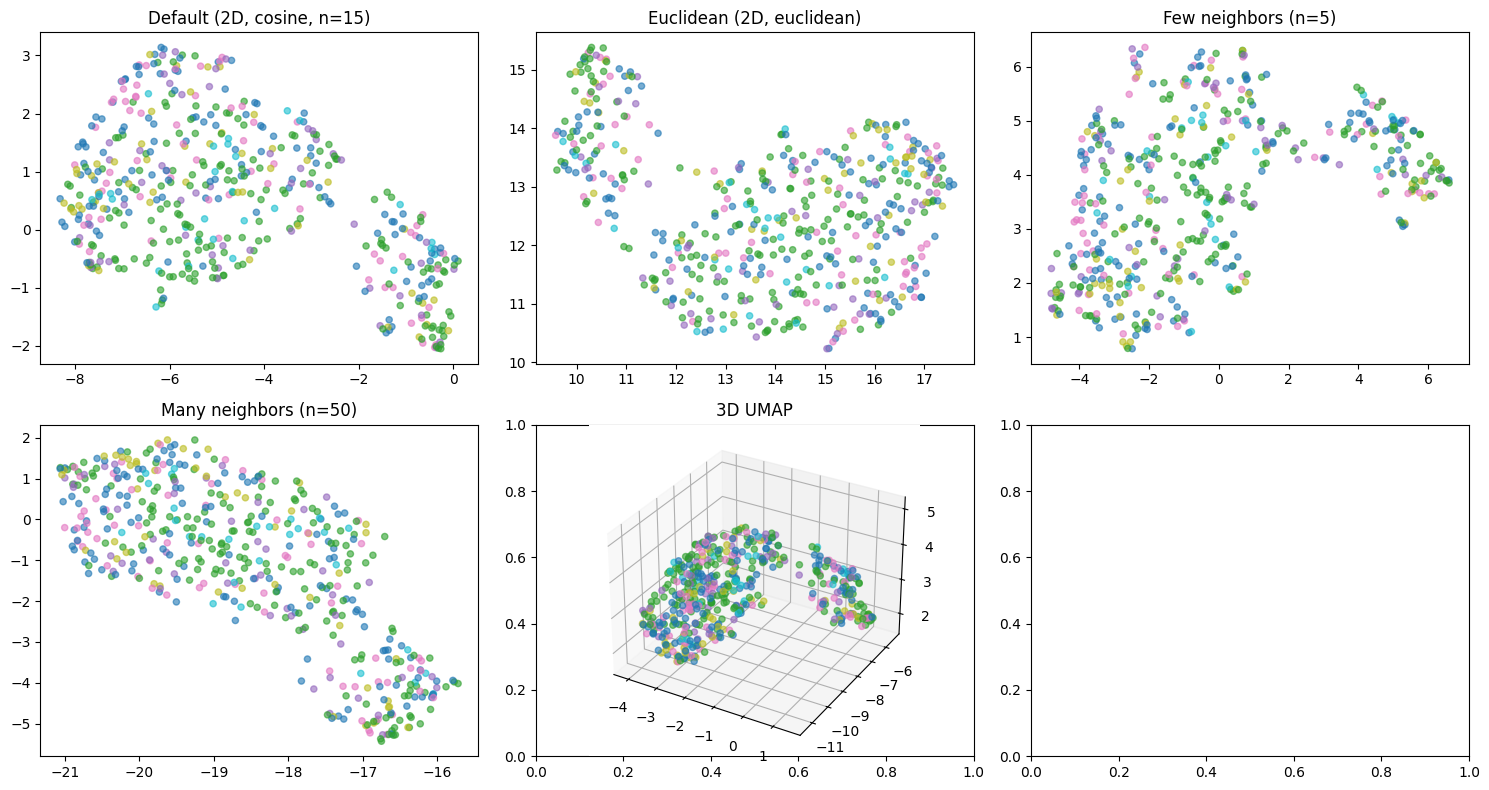

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
configs = [
    (umap_2d, 'Default (2D, cosine, n=15)', None),
    (umap_euc, 'Euclidean (2D, euclidean)', None),
    (umap_n5, 'Few neighbors (n=5)', None),
    (umap_n50, 'Many neighbors (n=50)', None),
    (umap_3d, '3D UMAP', '3d')
]
for idx, (data, title, proj) in enumerate(configs):
    ax = fig.add_subplot(2, 3, idx+1, projection=proj) if proj else axes[idx//3, idx%3]
    if proj == '3d':
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=y_sample, cmap='tab10', alpha=0.6, s=20)
    else:
        ax.scatter(data[:, 0], data[:, 1], c=y_sample, cmap='tab10', alpha=0.6, s=20)
    ax.set_title(title)
plt.tight_layout()
plt.show()


In [23]:
from sklearn.metrics import silhouette_score

configs = {"Default": umap_2d, "Euclidean": umap_euc, "Few n": umap_n5, "Many n": umap_n50, "3D": umap_3d}
for name, emb in configs.items():
    score = silhouette_score(emb if emb.shape[1] == 2 else emb[:, :2], y_sample)
    print(f"{name:15s}: {score:.4f}")


Default        : -0.0944
Euclidean      : -0.0998
Few n          : -0.1087
Many n         : -0.1038
3D             : -0.0809




##  Exercise 4: Fine-Tuning Hyperparameters

Fine-tuning performance depends heavily on hyperparameter choices. Let's experiment with the training configuration:


### Question 1: Experiment with TrainingArguments Hyperparameters

Modify the TrainingArguments to experiment with different hyperparameters. Try changing at least 2 of the following and observe the impact on model performance:

- **learning_rate**: Try values like 5e-5, 3e-5, or 1e-5
- **num_train_epochs**: Try 3 or 5 epochs
- **per_device_train_batch_size**: Try 32 or 128
- **weight_decay**: Try 0.001 or 0.1
- **warmup_steps**: Add warmup_steps=500 for learning rate warm-up

Consult the TrainingArguments documentation for all available options. Which combination gives the best F1-score?


In [24]:
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
import evaluate
import time

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

emotions_encoded = emotions.map(tokenize_function, batched=True)
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1_metric.compute(predictions=predictions, references=labels, average="weighted")


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [25]:
hyperparameter_configs = [
    {"name": "Baseline", "learning_rate": 2e-5, "num_train_epochs": 3, 
     "per_device_train_batch_size": 16, "weight_decay": 0.01, "warmup_steps": 0},
    {"name": "High LR", "learning_rate": 5e-5, "num_train_epochs": 5, 
     "per_device_train_batch_size": 16, "weight_decay": 0.01, "warmup_steps": 500},
    {"name": "Low LR", "learning_rate": 1e-5, "num_train_epochs": 3, 
     "per_device_train_batch_size": 16, "weight_decay": 0.01, "warmup_steps": 500},
    {"name": "Large Batch", "learning_rate": 3e-5, "num_train_epochs": 3, 
     "per_device_train_batch_size": 32, "weight_decay": 0.1, "warmup_steps": 500},
    {"name": "Small Batch", "learning_rate": 3e-5, "num_train_epochs": 3, 
     "per_device_train_batch_size": 32, "weight_decay": 0.001, "warmup_steps": 500}
]


In [26]:
results = []

for config in hyperparameter_configs:
    print(f"Training: {config['name']} (LR={config['learning_rate']}, Epochs={config['num_train_epochs']})")
    
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(labels))
    
    training_args = TrainingArguments(
        output_dir=f"./results_{config['name'].lower().replace(' ', '_')}",
        learning_rate=config['learning_rate'],
        num_train_epochs=config['num_train_epochs'],
        per_device_train_batch_size=config['per_device_train_batch_size'],
        per_device_eval_batch_size=16,
        weight_decay=config['weight_decay'],
        warmup_steps=config['warmup_steps'],
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        push_to_hub=False,
    )
    
    trainer = Trainer(
        model=model, args=training_args,
        train_dataset=emotions_encoded["train"],
        eval_dataset=emotions_encoded["validation"],
        tokenizer=tokenizer, data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time
    
    eval_results = trainer.evaluate()
    results.append({
        "config": config['name'],
        "f1_score": eval_results.get("eval_f1", 0),
        "training_time": training_time,
        **{k: config[k] for k in ['learning_rate', 'num_train_epochs', 'per_device_train_batch_size', 'weight_decay', 'warmup_steps']}
    })
    
    print(f"  F1: {eval_results.get('eval_f1', 0):.4f}, Time: {training_time:.1f}s")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training: Baseline (LR=2e-05, Epochs=3)


Epoch,Training Loss,Validation Loss,F1
1,0.254400,0.194552,0.928433
2,0.149000,0.181788,0.938988
3,0.100200,0.157451,0.938893


  F1: 0.9390, Time: 1517.1s
Training: High LR (LR=5e-05, Epochs=5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.272900,0.217235,0.927101
2,0.158200,0.179238,0.933395
3,0.111500,0.181819,0.936674
4,0.081100,0.223104,0.937734
5,0.040500,0.281479,0.933726


  F1: 0.9377, Time: 1565.0s
Training: Low LR (LR=1e-05, Epochs=3)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.440000,0.250341,0.916423
2,0.187100,0.180580,0.933740
3,0.122900,0.163963,0.938457


  F1: 0.9385, Time: 1015.9s
Training: Large Batch (LR=3e-05, Epochs=3)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.929200,0.252077,0.914498
2,0.184900,0.140188,0.935095
3,0.104800,0.130973,0.940126


  F1: 0.9401, Time: 1079.0s
Training: Small Batch (LR=3e-05, Epochs=3)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.929400,0.252948,0.913431
2,0.184500,0.146479,0.933918
3,0.104800,0.132741,0.942557


  F1: 0.9426, Time: 853.0s


        config  f1_score  training_time  learning_rate
4  Small Batch  0.942557     853.000371        0.00003
3  Large Batch  0.940126    1078.956769        0.00003
0     Baseline  0.938988    1517.062517        0.00002
2       Low LR  0.938457    1015.900006        0.00001
1      High LR  0.937734    1565.017179        0.00005


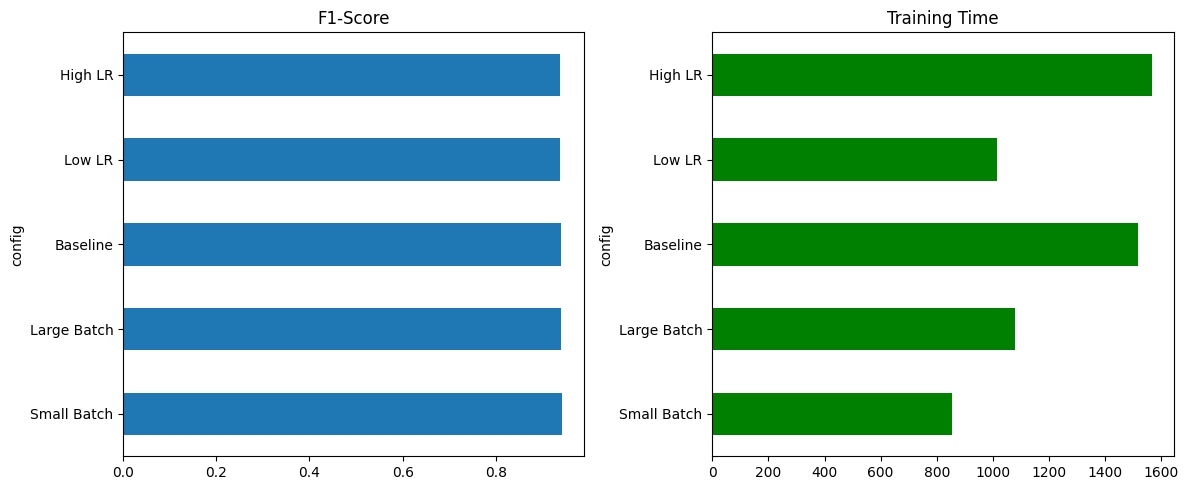

Best: Small Batch (F1: 0.9426)


In [27]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('f1_score', ascending=False)

print(results_df[['config', 'f1_score', 'training_time', 'learning_rate']])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
results_df.plot(x='config', y='f1_score', kind='barh', ax=axes[0], legend=False)
axes[0].set_title('F1-Score')
results_df.plot(x='config', y='training_time', kind='barh', ax=axes[1], color='green', legend=False)
axes[1].set_title('Training Time')
plt.tight_layout()
plt.show()

best = results_df.iloc[0]
print(f"Best: {best['config']} (F1: {best['f1_score']:.4f})")


### Question 2: Compare Different Pre-trained Models

Try fine-tuning a different pre-trained model (e.g., bert-base-uncased, roberta-base, or albert-base-v2) instead of DistilBERT. How does the training time and final performance compare? What trade-offs do you observe between model size and accuracy?


In [28]:
models_to_test = [
    {"name": "DistilBERT", "model_id": "distilbert-base-uncased"},
    {"name": "BERT", "model_id": "bert-base-uncased"},
    {"name": "RoBERTa", "model_id": "roberta-base"},
    {"name": "ALBERT", "model_id": "albert-base-v2"}
]


In [29]:
model_results = []

try:
    best = results_df.iloc[0]
    best_lr, best_epochs = best['learning_rate'], int(best['num_train_epochs'])
    best_batch_size, best_weight_decay = int(best['per_device_train_batch_size']), best['weight_decay']
    best_warmup = int(best['warmup_steps'])
except:
    best_lr, best_epochs, best_batch_size = 3e-5, 3, 16
    best_weight_decay, best_warmup = 0.01, 500

for model_info in models_to_test:
    print(f"Training: {model_info['name']}...")
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_info['model_id'])
        model = AutoModelForSequenceClassification.from_pretrained(model_info['model_id'], num_labels=len(labels))
        
        def tokenize_function(examples):
            return tokenizer(examples["text"], truncation=True, max_length=512)
        
        emotions_encoded_model = emotions.map(tokenize_function, batched=True)
        emotions_encoded_model.set_format("torch", columns=["input_ids", "attention_mask", "label"])
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        
        training_args = TrainingArguments(
            output_dir=f"./results_{model_info['name'].lower()}",
            learning_rate=best_lr, num_train_epochs=best_epochs,
            per_device_train_batch_size=best_batch_size, per_device_eval_batch_size=16,
            weight_decay=best_weight_decay, warmup_steps=best_warmup,
            eval_strategy="epoch", save_strategy="epoch",
            load_best_model_at_end=True, metric_for_best_model="f1", push_to_hub=False,
        )
        
        trainer = Trainer(
            model=model, args=training_args,
            train_dataset=emotions_encoded_model["train"],
            eval_dataset=emotions_encoded_model["validation"],
            tokenizer=tokenizer, data_collator=data_collator, compute_metrics=compute_metrics,
        )
        
        start_time = time.time()
        trainer.train()
        training_time = time.time() - start_time
        
        eval_results = trainer.evaluate()
        num_params = sum(p.numel() for p in model.parameters())
        model_size_mb = num_params * 4 / (1024 * 1024)
        
        model_results.append({
            "model": model_info['name'],
            "f1_score": eval_results.get("eval_f1", 0),
            "training_time": training_time,
            "model_size_mb": model_size_mb
        })
        
        print(f"  F1: {eval_results.get('eval_f1', 0):.4f}, Time: {training_time:.1f}s, Size: {model_size_mb:.1f}MB")
    except Exception as e:
        print(f"  Error: {str(e)}")
        continue


Training: DistilBERT...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,F1
1,0.929300,0.252509,0.913431
2,0.185000,0.146251,0.932865
3,0.104900,0.132606,0.941038


  F1: 0.9410, Time: 871.0s, Size: 255.4MB
Training: BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,F1
1,0.947700,0.257196,0.918101
2,0.178100,0.149809,0.937468
3,0.097200,0.144627,0.938490


  F1: 0.9385, Time: 2535.2s, Size: 417.7MB
Training: RoBERTa...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss


  Error: MPS backend out of memory (MPS allocated: 6.09 GiB, other allocations: 12.04 GiB, max allowed: 18.13 GiB). Tried to allocate 6.19 MiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Training: ALBERT...


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

  Error: MPS backend out of memory (MPS allocated: 6.09 GiB, other allocations: 12.03 GiB, max allowed: 18.13 GiB). Tried to allocate 14.65 MiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


        model  f1_score  training_time  model_size_mb
0  DistilBERT  0.941038     870.979295     255.424828
1        BERT  0.938490    2535.201955     417.659203


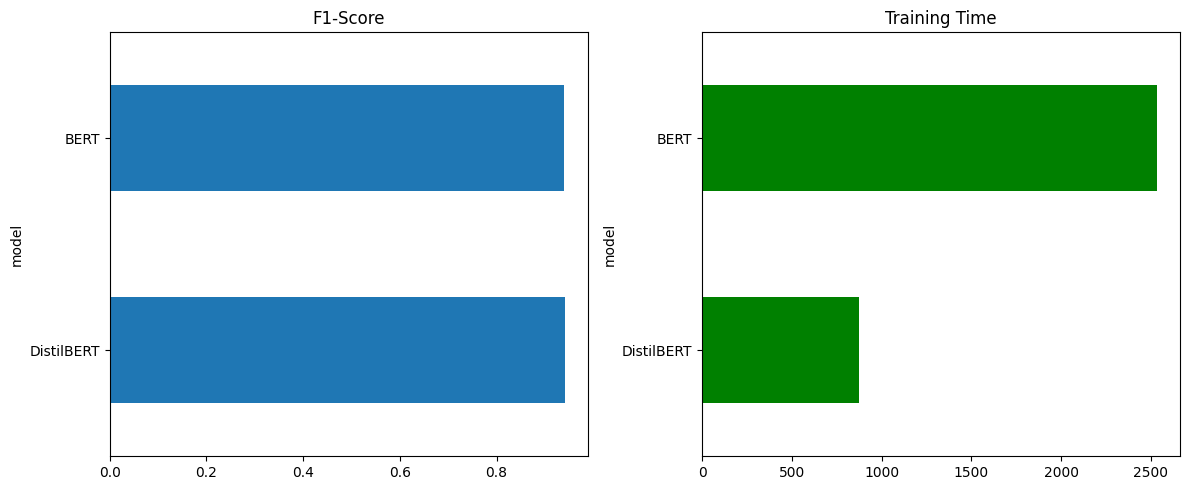

Best: DistilBERT (F1: 0.9410, Time: 871.0s)


In [30]:
if model_results:
    model_results_df = pd.DataFrame(model_results)
    model_results_df = model_results_df.sort_values('f1_score', ascending=False)
    
    print(model_results_df)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    model_results_df.plot(x='model', y='f1_score', kind='barh', ax=axes[0], legend=False)
    axes[0].set_title('F1-Score')
    model_results_df.plot(x='model', y='training_time', kind='barh', ax=axes[1], color='green', legend=False)
    axes[1].set_title('Training Time')
    plt.tight_layout()
    plt.show()
    
    best = model_results_df.iloc[0]
    print(f"Best: {best['model']} (F1: {best['f1_score']:.4f}, Time: {best['training_time']:.1f}s)")



##  Exercise 5: Model Deployment and Inference

Now that you have a trained model, let's explore deployment options:


### Question 1: Hugging Face Inference API

Read about the Hugging Face Inference API and test your deployed model via HTTP requests. Write a Python function using the `requests` library to send text to your model and receive predictions. How would you integrate this into a web application?


In [ ]:

from transformers import pipeline
import torch

# Force CPU to avoid MPS memory issues on Mac
device = "cpu"

# Using a working emotion classification model
emotion_classifier = pipeline("text-classification", 
                             model="SamLowe/roberta-base-go_emotions",
                             return_all_scores=True,
                             device=device)


test_texts = ["I'm feeling great today!", "This is so frustrating."]

for text in test_texts:
    result = emotion_classifier(text)
    print(f"\nText: '{text}'")
    for pred in result[0][:3]:
        print(f"  {pred.get('label', 'N/A')}: {pred.get('score', 0):.4f}")


Device set to use cpu



Text: 'I'm feeling great today!'
  admiration: 0.3179
  amusement: 0.0030
  anger: 0.0014

Text: 'This is so frustrating.'
  admiration: 0.0034
  amusement: 0.0028
  anger: 0.4851


In [36]:
sample_text = "I'm so excited about this project!"
result = emotion_classifier(sample_text)
predictions = sorted(result[0], key=lambda x: x.get('score', 0), reverse=True)

print(f"Text: '{sample_text}'")
for i, pred in enumerate(predictions, 1):
    print(f"  {i}. {pred.get('label', 'N/A'):15s}: {pred.get('score', 0):.4f}")


Text: 'I'm so excited about this project!'
  1. excitement     : 0.8248
  2. joy            : 0.0435
  3. neutral        : 0.0393
  4. curiosity      : 0.0377
  5. approval       : 0.0210
  6. surprise       : 0.0185
  7. admiration     : 0.0131
  8. amusement      : 0.0118
  9. desire         : 0.0105
  10. love           : 0.0104
  11. gratitude      : 0.0082
  12. confusion      : 0.0074
  13. optimism       : 0.0067
  14. fear           : 0.0053
  15. caring         : 0.0050
  16. nervousness    : 0.0046
  17. annoyance      : 0.0045
  18. realization    : 0.0039
  19. disapproval    : 0.0038
  20. sadness        : 0.0024
  21. disgust        : 0.0023
  22. anger          : 0.0022
  23. disappointment : 0.0018
  24. relief         : 0.0018
  25. embarrassment  : 0.0013
  26. pride          : 0.0013
  27. remorse        : 0.0008
  28. grief          : 0.0006


#### Web Application Integration Example

Here's how you could integrate this into a web application (Flask example):


In [ ]:
flask_example = '''
from flask import Flask, request, jsonify, render_template_string
from transformers import pipeline

app = Flask(__name__)

# Load model once at startup (no API needed)
emotion_classifier = pipeline("text-classification", 
                             model="SamLowe/roberta-base-go_emotions",
                             return_all_scores=True)

@app.route('/')
def index():
    html = """<html><body><h1>Emotion Classification</h1>
    <form action="/predict" method="post">
    <textarea name="text" rows="4" cols="50" placeholder="Enter text here..."></textarea><br>
    <button type="submit">Classify</button></form></body></html>"""
    return render_template_string(html)

@app.route('/predict', methods=['POST'])
def predict():
    text = request.form.get('text', '')
    if not text:
        return jsonify({'error': 'No text provided'}), 400
    
    # Use local pipeline instead of API
    result = emotion_classifier(text)
    return jsonify(result)

@app.route('/api/predict', methods=['POST'])
def api_predict():
    """REST API endpoint"""
    data = request.get_json()
    text = data.get('text', '') if data else ''
    
    if not text:
        return jsonify({'error': 'No text provided'}), 400
    
    result = emotion_classifier(text)
    return jsonify(result)

if __name__ == '__main__':
    app.run(debug=True)
'''

print(flask_example,"GO SEE THE APP.PY FILE, command on the shell : python3 app.py on MAC OSx")



from flask import Flask, request, jsonify, render_template_string
from transformers import pipeline

app = Flask(__name__)

# Load model once at startup (no API needed)
emotion_classifier = pipeline("text-classification", 
                             model="SamLowe/roberta-base-go_emotions",
                             return_all_scores=True)

@app.route('/')
def index():
    html = """<html><body><h1>Emotion Classification</h1>
    <form action="/predict" method="post">
    <textarea name="text" rows="4" cols="50" placeholder="Enter text here..."></textarea><br>
    <button type="submit">Classify</button></form></body></html>"""
    return render_template_string(html)

@app.route('/predict', methods=['POST'])
def predict():
    text = request.form.get('text', '')
    if not text:
        return jsonify({'error': 'No text provided'}), 400

    # Use local pipeline instead of API
    result = emotion_classifier(text)
    return jsonify(result)

@app.route('/api/predict', methods=['PO

### Question 2: Pipeline Parameters and Different Tasks

The pipeline returns probabilities for all classes with `return_all_scores=True`. Explore the pipeline documentation and try different parameters like `top_k`, `truncation`, and `max_length`. How do these parameters affect the inference results? Try creating a pipeline for a different task (e.g., `sentiment-analysis` or `zero-shot-classification`).


In [ ]:
from transformers import pipeline

emotion_classifier = pipeline("text-classification", 
                             model="bhadresh-savani/emotion_english_distilroberta_base",
                             return_all_scores=True,
                             device="cpu")

test_text = "I'm feeling absolutely amazing today!"


: 

In [ ]:
result_all = emotion_classifier(test_text)
print("All scores:")
for pred in result_all[0][:3]:
    print(f"  {pred['label']:15s}: {pred['score']:.4f}")

emotion_topk = pipeline("text-classification", 
                       model="bhadresh-savani/emotion_english_distilroberta_base",
                       top_k=3,
                       device="cpu")
result_topk = emotion_topk(test_text)
print("\ntop_k=3:")
if isinstance(result_topk, list) and len(result_topk) > 0:
    if isinstance(result_topk[0], list):
        result_topk = result_topk[0]
    for pred in result_topk:
        if isinstance(pred, dict):
            print(f"  {pred.get('label', 'N/A'):15s}: {pred.get('score', 0):.4f}")

long_text = "This is a very long text. " * 20
emotion_trunc = pipeline("text-classification", 
                        model="bhadresh-savani/emotion_english_distilroberta_base",
                        truncation=True, max_length=50,
                        device="cpu")
result_trunc = emotion_trunc(long_text)
print(f"\nTruncation (max_length=50): {result_trunc[0]['label']} ({result_trunc[0]['score']:.4f})")


In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis", 
                             model="cardiffnlp/twitter-roberta-base-sentiment-latest",
                             return_all_scores=True,
                             device="cpu")

sentiment_texts = ["I love this product!", "This is terrible."]

for text in sentiment_texts:
    result = sentiment_pipeline(text)
    print(f"\nText: '{text}'")
    for pred in result[0][:2]:
        print(f"  {pred['label']:20s}: {pred['score']:.4f}")


In [ ]:
zero_shot = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device="cpu")

text = "The new iPhone has amazing features and great battery life."
labels = ["technology", "sports", "politics", "entertainment", "business"]

result = zero_shot(text, labels)
print(f"Text: '{text}'")
for i, (label, score) in enumerate(zip(result['labels'], result['scores']), 1):
    print(f"  {i}. {label:15s}: {score:.4f}")

emotion_labels = ["joy", "sadness", "anger", "fear", "surprise", "love"]
result_emotions = zero_shot(text, emotion_labels)
print(f"\nWith emotion labels:")
for i, (label, score) in enumerate(zip(result_emotions['labels'], result_emotions['scores']), 1):
    print(f"  {i}. {label:15s}: {score:.4f}")




## Exercise 6: Advanced Evaluation Metrics

Understanding different evaluation metrics is crucial for assessing model performance, especially with imbalanced datasets:


In [ ]:
# Ensure data is loaded
from datasets import load_dataset
if 'val_df' not in globals() or 'labels' not in globals():
    emotions = load_dataset("emotion")
    labels = emotions["train"].features["label"].names
    val_df = emotions["validation"].to_pandas()
    print(f"Data loaded: {len(val_df)} validation examples")


### Question 1: Additional Evaluation Metrics

We've used accuracy and F1-score, but there are many other metrics. Read the scikit-learn metrics documentation and implement at least two additional metrics:

- Precision and Recall per class
- Macro vs Micro vs Weighted F1-score
- Cohen's Kappa score
- Matthews Correlation Coefficient (MCC)

Which metric would you prioritize for this emotion classification task and why?


In [ ]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    cohen_kappa_score, matthews_corrcoef,
    classification_report, confusion_matrix
)
import numpy as np
from transformers import pipeline

classifier = pipeline("text-classification", 
                     model="bhadresh-savani/emotion_english_distilroberta_base",
                     return_all_scores=False)

sample_size = 200
val_texts_sample = val_df["text"].head(sample_size).tolist()
y_true_sample = val_df["label"].head(sample_size).values

label_mapping = {label: idx for idx, label in enumerate(labels)}
y_pred_sample = []

for text in val_texts_sample:
    result = classifier(text)
    pred_label = result[0]['label'].lower()
    if pred_label in label_mapping:
        y_pred_sample.append(label_mapping[pred_label])
    else:
        y_pred_sample.append(0)

y_pred_sample = np.array(y_pred_sample)
print(f"Evaluating on {len(y_true_sample)} samples")


In [ ]:
import matplotlib.pyplot as plt
precision_per_class = precision_score(y_true_sample, y_pred_sample, average=None, zero_division=0)
recall_per_class = recall_score(y_true_sample, y_pred_sample, average=None, zero_division=0)
f1_per_class = f1_score(y_true_sample, y_pred_sample, average=None, zero_division=0)

print("Per-class metrics:")
print(f"{'Class':<15s} {'Precision':<12s} {'Recall':<12s} {'F1':<12s}")
for i, label in enumerate(labels):
    print(f"{label:<15s} {precision_per_class[i]:<12.4f} {recall_per_class[i]:<12.4f} {f1_per_class[i]:<12.4f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].bar(range(len(labels)), precision_per_class)
axes[0].set_title('Precision')
axes[0].set_xticks(range(len(labels)))
axes[0].set_xticklabels(labels, rotation=45, ha='right')
axes[1].bar(range(len(labels)), recall_per_class, color='green')
axes[1].set_title('Recall')
axes[1].set_xticks(range(len(labels)))
axes[1].set_xticklabels(labels, rotation=45, ha='right')
axes[2].bar(range(len(labels)), f1_per_class, color='orange')
axes[2].set_title('F1-Score')
axes[2].set_xticks(range(len(labels)))
axes[2].set_xticklabels(labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
f1_macro = f1_score(y_true_sample, y_pred_sample, average='macro', zero_division=0)
f1_micro = f1_score(y_true_sample, y_pred_sample, average='micro', zero_division=0)
f1_weighted = f1_score(y_true_sample, y_pred_sample, average='weighted', zero_division=0)

print(f"Macro: {f1_macro:.4f}, Micro: {f1_micro:.4f}, Weighted: {f1_weighted:.4f}")

fig, ax = plt.subplots(figsize=(8, 5))
metrics = ['Macro', 'Micro', 'Weighted']
scores = [f1_macro, f1_micro, f1_weighted]
ax.bar(metrics, scores, alpha=0.7)
ax.set_title('F1-Score Comparison')
ax.set_ylabel('F1-Score')
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()


In [ ]:
kappa = cohen_kappa_score(y_true_sample, y_pred_sample)
print(f"Cohen's Kappa: {kappa:.4f}")


In [ ]:
mcc = matthews_corrcoef(y_true_sample, y_pred_sample)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


In [ ]:
report = classification_report(y_true_sample, y_pred_sample, target_names=labels, zero_division=0)
print(report)

metrics_summary = {
    'Accuracy': (y_true_sample == y_pred_sample).mean(),
    'F1-Macro': f1_macro,
    'F1-Micro': f1_micro,
    'F1-Weighted': f1_weighted,
    "Cohen's Kappa": kappa,
    'MCC': mcc
}

print("\nAll metrics:")
for metric, value in metrics_summary.items():
    print(f"  {metric:20s}: {value:.4f}")


### Question 2: Misclassification Analysis and Data Augmentation

The confusion matrix shows which classes are most confused. Create a function that:

1. Extracts the top 10 most misclassified examples (where the model was most confident but wrong)
2. Identifies patterns in these misclassifications
3. Suggests specific data augmentation strategies to improve performance on these difficult cases


In [ ]:
import pandas as pd
misclassification_data = []

for idx, text in enumerate(val_texts_sample):
    true_label = y_true_sample[idx]
    result = classifier(text)
    pred_label = result[0]['label'].lower()
    pred_score = result[0]['score']
    
    if pred_label in label_mapping:
        pred_label_idx = label_mapping[pred_label]
    else:
        pred_label_idx = 0
    
    is_correct = (true_label == pred_label_idx)
    
    misclassification_data.append({
        'text': text,
        'true_label': true_label,
        'true_label_name': labels[true_label],
        'pred_label': pred_label_idx,
        'pred_label_name': labels[pred_label_idx] if pred_label_idx < len(labels) else pred_label,
        'confidence': pred_score,
        'is_correct': is_correct
    })

misclass_df = pd.DataFrame(misclassification_data)
print(f"Total: {len(misclass_df)}, Correct: {misclass_df['is_correct'].sum()}, Misclassified: {(~misclass_df['is_correct']).sum()}")


In [ ]:
def get_top_misclassifications(df, top_n=10):
    misclassified = df[~df['is_correct']].copy()
    return misclassified.nlargest(top_n, 'confidence')

top_misclass = get_top_misclassifications(misclass_df, top_n=10)

for idx, row in top_misclass.iterrows():
    text_preview = row['text'][:80] + '...' if len(row['text']) > 80 else row['text']
    print(f"\nExample {idx + 1}:")
    print(f"  Text: '{text_preview}'")
    print(f"  True: {row['true_label_name']}, Predicted: {row['pred_label_name']}, Confidence: {row['confidence']:.4f}")


In [ ]:
from collections import Counter
misclass_confusion = pd.crosstab(
    misclass_df[~misclass_df['is_correct']]['true_label_name'],
    misclass_df[~misclass_df['is_correct']]['pred_label_name'],
    margins=True
)
print(misclass_confusion)

confusion_pairs = [(row['true_label_name'], row['pred_label_name']) 
                   for idx, row in misclass_df[~misclass_df['is_correct']].iterrows()]
pair_counts = Counter(confusion_pairs)

print("\nTop confusion pairs:")
for (true_label, pred_label), count in pair_counts.most_common(10):
    print(f"  {true_label:15s} → {pred_label:15s}: {count} times")

fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_true_sample, y_pred_sample, labels=range(len(labels)))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
       xticklabels=labels, yticklabels=labels,
       title='Confusion Matrix', ylabel='True Label', xlabel='Predicted Label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


In [ ]:

misclassified_texts = misclass_df[~misclass_df['is_correct']].copy()
misclassified_texts['text_length'] = misclassified_texts['text'].str.len()
misclassified_texts['word_count'] = misclassified_texts['text'].str.split().str.len()

correct_texts = misclass_df[misclass_df['is_correct']].copy()
correct_texts['text_length'] = correct_texts['text'].str.len()
correct_texts['word_count'] = correct_texts['text'].str.split().str.len()

print(f"Misclassified - Avg length: {misclassified_texts['text_length'].mean():.1f} chars, Avg words: {misclassified_texts['word_count'].mean():.1f}")
print(f"Correct - Avg length: {correct_texts['text_length'].mean():.1f} chars, Avg words: {correct_texts['word_count'].mean():.1f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(misclassified_texts['text_length'], bins=20, alpha=0.7, label='Misclassified', color='red')
axes[0].hist(correct_texts['text_length'], bins=20, alpha=0.7, label='Correct', color='green')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Text Length Distribution')
axes[0].legend()

axes[1].hist(misclassified_texts['word_count'], bins=20, alpha=0.7, label='Misclassified', color='red')
axes[1].hist(correct_texts['word_count'], bins=20, alpha=0.7, label='Correct', color='green')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Word Count Distribution')
axes[1].legend()
plt.tight_layout()
plt.show()
